In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf


In [93]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [94]:
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'title_year', 'actor_2_facebook_likes', 'aspect_ratio']
predictors_actors = ['director_high', 'director_low', 'actor_1_high', 'actor_1_low', 'actor_2_high', 'actor_2_low', 'actor_3_high', 'actor_3_low']
predictors_genre = ['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western']
logistic_model = smf.logit(formula='profit_binary ~ ' + ' + '.join(predictors_actors) + ' + ' + ' + '.join(predictors_genre) + ' + ' + ' + '.join(standard_predictors), data=train).fit()


Optimization terminated successfully.
         Current function value: 0.337885
         Iterations 25


In [95]:
#summary
logistic_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2968
Method:                           MLE   Df Model:                           29
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.5105
Time:                        14:40:43   Log-Likelihood:                -1013.0
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    13.0851        nan        nan        nan         nan         nan
director_high                 7.3422        nan        nan        nan         nan         nan
director_low                  5.7429        nan        nan        nan         nan         nan
actor_1_high                  6.9394        nan        nan        nan         nan         nan
actor_1_low                   6.1457        nan        nan        nan         nan         nan
actor_2_high                  7.3407        nan        nan        nan         nan         nan
actor_2_low                   5.7444        nan        nan        nan         nan         nan
actor_3_high                  7.7487        nan        nan        nan         nan         nan
actor_3_low                   5.3363        nan        nan        nan         nan         nan
action                       -0.1681      0.160     -1.049      0.294      -0.482       0.146
biography                    -0.0905      0.261     -0.346      0.729      -0.603       0.422
comedy                       -0.3587      0.157     -2.282      0.022      -0.667      -0.051
crime                         0.0445      0.158      0.281      0.778      -0.266       0.355
documentary                   1.5364      0.628      2.446      0.014       0.305       2.767
drama                         0.1090      0.142      0.766      0.444      -0.170       0.388
history                       0.2107      0.320      0.659      0.510      -0.416       0.837
horror                        0.5139      0.224      2.291      0.022       0.074       0.953
music                         0.1058      0.316      0.335      0.738      -0.513       0.724
musical                      -0.0056      0.409     -0.014      0.989      -0.808       0.797
mystery                       0.1483      0.203      0.731      0.465      -0.249       0.546
romance                       0.1440      0.144      0.997      0.319      -0.139       0.427
sport                        -0.1487      0.294     -0.506      0.613      -0.724       0.427
thriller                     -0.0905      0.161     -0.563      0.574      -0.406       0.225
war                           0.1366      0.313      0.437      0.662      -0.476       0.749
western                      -0.3946      0.536     -0.736      0.462      -1.445       0.656
duration                     -0.0062      0.003     -1.901      0.057      -0.013       0.000
director_facebook_likes   -6.311e-06   1.87e-05     -0.337      0.736    -4.3e-05    3.03e-05
actor_3_facebook_likes     6.851e-06   7.93e-05      0.086      0.931      -0.000       0.000
actor_1_facebook_likes     1.599e-05    4.7e-05      0.340      0.734   -7.61e-05       0.000
cast_total_facebook_likes -1.904e-05    4.7e-05     -0.405      0.685      -0.000     7.3e-05
facenumber_in_poster         -0.0065      0.028     -0.229      0.819      -0.062       0.049
title_year                   -0.0187      0.0

In [96]:
#pred on test
test['pred'] = logistic_model.predict(test)

#make binary prediction
test['pred_binary'] = np.where(test['pred'] > 0.5, 1, 0)

In [97]:
#accuracy on test
accuracy = sum(test['pred_binary'] == test['profit_binary'])/len(test)
print(accuracy)

0.868


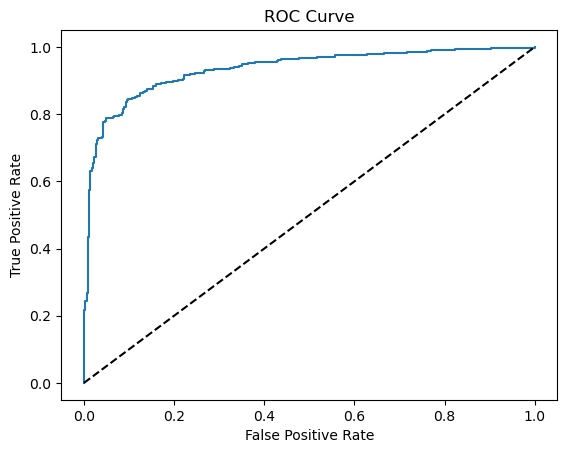

In [98]:
#plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test['profit_binary'], test['pred'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [99]:
#Function to compute confusion matrix and prediction accuracy on test/train data
from sklearn.metrics import auc


def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))


Classification accuracy = 86.8%
Precision = 88.8%
TPR or Recall = 86.4%
FNR = 13.6%
FPR = 12.7%
ROC-AUC = 93.3%


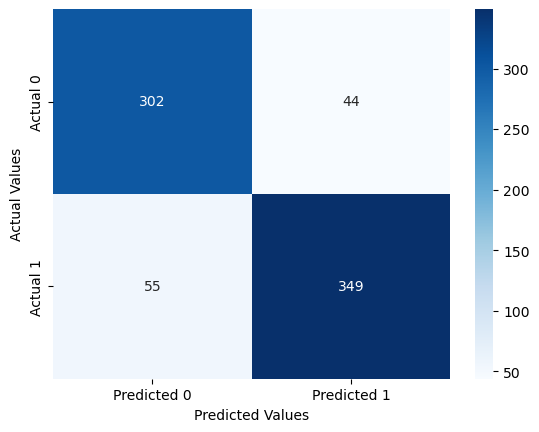

In [100]:
#run confusion_matrix_data like confusion_matrix_data(test,test.Outcome,logit_model_diabetes,0.3)
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)


In [101]:
#print equation model
print(logistic_model.summary())

                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2968
Method:                           MLE   Df Model:                           29
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.5105
Time:                        14:40:44   Log-Likelihood:                -1013.0
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    13.0851        nan        nan        nan         nan         nan
director_high                 7.3422        nan        nan        nan         nan     

In [102]:
equation = logistic_model.params

print('Model equation:')
print(equation)

Model equation:
Intercept                    13.085072
director_high                 7.342182
director_low                  5.742905
actor_1_high                  6.939393
actor_1_low                   6.145694
actor_2_high                  7.340725
actor_2_low                   5.744354
actor_3_high                  7.748748
actor_3_low                   5.336334
action                       -0.168141
biography                    -0.090539
comedy                       -0.358746
crime                         0.044542
documentary                   1.536358
drama                         0.108969
history                       0.210660
horror                        0.513879
music                         0.105792
musical                      -0.005553
mystery                       0.148257
romance                       0.144008
sport                        -0.148734
thriller                     -0.090471
war                           0.136558
western                      -0.394608
duration 

In [103]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load train and test datasets

#conmbine predictors_actors + predictors_genre into one list
predictors = predictors_actors + predictors_genre

# Split train dataset into features (X) and target variable (y)
X_train = train[predictors]
y_train = train['profit_binary']

# Split test dataset into features (X) and target variable (y)
X_test = test[predictors]
y_test = test['profit_binary']

# Initialize logistic regression model
logreg = LogisticRegression()

# Fit model on training data
logreg.fit(X_train, y_train)

# Make predictions on test data
y_pred = logreg.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.86      0.86       346
           1       0.88      0.87      0.87       404

    accuracy                           0.87       750
   macro avg       0.86      0.87      0.86       750
weighted avg       0.87      0.87      0.87       750



In [104]:
# Import RFE from scikit-learn
from sklearn.feature_selection import RFE

# Define the model to use
model = LogisticRegression()

# Combine predictors_actors and predictors_genre into one list
predictors = predictors_actors + predictors_genre

# Set the number of features to remove at each step
step = 1

# Initialize RFE with the logistic regression model and step size
rfe = RFE(estimator=model, n_features_to_select=step)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the ranking of each feature
ranking = rfe.ranking_

# Create a list of selected features based on their ranking
selected_features = [predictors[i] for i in range(len(predictors)) if ranking[i] == 1]

# Fit the logistic regression model on the selected features
logistic_model_backwards = smf.logit(formula = 'profit_binary ~ ' + ' + '.join(selected_features), data = train).fit()

# Print the summary of the model
print(logistic_model_backwards.summary())


Optimization terminated successfully.
         Current function value: 0.438929
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.3642
Time:                        14:40:44   Log-Likelihood:                -1315.9
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7714      0.071     24.944      0.000       1.632       1.911
actor_3_low    -3.3090    

In [105]:
#new model w jsut actor_3_low

log_model_2 = smf.logit(formula = 'profit_binary ~ actor_3_low', data = train).fit()

# Print the summary of the model
print(log_model_2.summary())


Optimization terminated successfully.
         Current function value: 0.438929
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.3642
Time:                        14:40:44   Log-Likelihood:                -1315.9
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7714      0.071     24.944      0.000       1.632       1.911
actor_3_low    -3.3090    

In [106]:
#accruacy on test
test['pred'] = log_model_2.predict(test)
test['pred_binary'] = np.where(test['pred'] > 0.5, 1, 0)
accuracy = sum(test['pred_binary'] == test['profit_binary'])/len(test)
print(accuracy)


0.8453333333333334


In [107]:
#coeff
print(log_model_2.params)

Intercept      1.771439
actor_3_low   -3.309000
dtype: float64
